ReAct [@yao2022react] is a method that uses Large Language Models (LLMs) to create reasoning and actions for tasks in an interleaved way. Reasoning helps the model to create, monitor and adjust action plans and handle exceptions. Actions allows the model to access knowledge bases or external environments to obtain more information to support its reasoning, as illustrated in the following figure:

<div style="text-align: center;">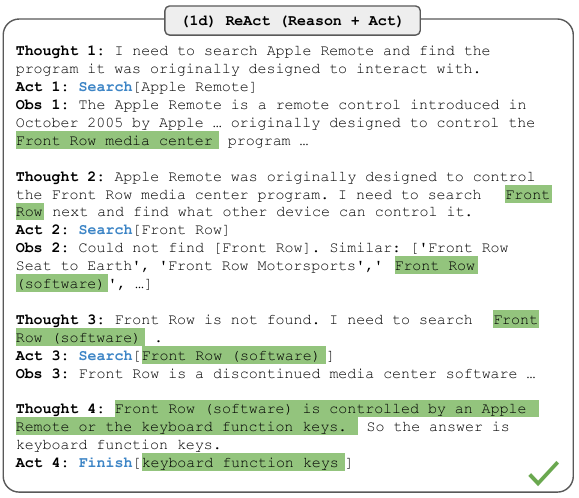{.preview-image}
<br/>Image source: Yao et al. [@yao2022react]
</div>

This notebook uses LangChain agent to try ReAct with Llama 2.

In [1]:
#| echo: False

import warnings
warnings.filterwarnings('ignore')

## Load Llama 2 70B-chat

In [2]:
#| code-fold: true
#| code-summary: Configure HuggingFace token (click to toggle the content)

from getpass import getpass

hf_token = getpass()

 ········


In [3]:
#| code-fold: show
#| code-summary: Load the model (click to toggle the content)

import torch
from transformers import pipeline, GenerationConfig


model_id = 'meta-llama/Llama-2-70b-chat-hf'

gen_config = GenerationConfig.from_pretrained(
    model_id,
    token=hf_token
)
gen_config.max_new_tokens = 2000
gen_config.temperature = 1e-10

pipe = pipeline(
    task="text-generation",
    model=model_id,
    return_full_text=True,
    generation_config=gen_config,
    device_map='auto',
    model_kwargs={
        'load_in_4bit': True,
        'bnb_4bit_quant_type': 'nf4',
        'bnb_4bit_use_double_quant': True,
        'bnb_4bit_compute_dtype': torch.bfloat16,
    },
    use_auth_token=hf_token,
    repetition_penalty=1.1
)

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

## Set up LangChain ReAct agent

In [4]:
#| code-fold: show
#| code-summary: Initialize an agent (click to toggle the content)

from langchain import Wikipedia
from langchain.llms import HuggingFacePipeline
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.agents.react.base import DocstoreExplorer


docstore = DocstoreExplorer(Wikipedia())

tools = [
    Tool(
        name="Search",
        func=docstore.search,
        description="useful for when you need to ask with search",
    ),
    Tool(
        name="Lookup",
        func=docstore.lookup,
        description="useful for when you need to ask with lookup",
    )
]

llm = HuggingFacePipeline(pipeline=pipe)

react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.REACT_DOCSTORE,
    verbose=True)

## Ask some questions

In [5]:
react_agent.run('Who are the directors of the movies that caused the Barbenheimer phenomenon?')



> Entering new AgentExecutor chain...
Thought: I need to search Barbenheimer phenomenon, find the movies associated with it, then find the directors of those movies.
Action: Search[Barbenheimer phenomenon]
Observation: Barbenheimer is a cultural phenomenon that began on the Internet before the simultaneous theatrical release of two blockbuster films: Warner Bros. Pictures's  Barbie and Universal Pictures's Oppenheimer, on July 21, 2023 in the United States and several other countries. The word is a portmanteau of the films' titles. The contrast of Barbie—a fantasy comedy by Greta Gerwig about the fashion doll Barbie—and Oppenheimer—an epic biographical thriller by Christopher Nolan about physicist J. Robert Oppenheimer, scientific director of the Manhattan Project—prompted a comedic response from Internet users, including memes and merchandise. Polygon described the two films as "extreme opposites", and Variety called the phenomenon "the movie event of the year".The phenomenon began 

'Greta Gerwig, Christopher Nolan'

In [6]:
react_agent.run('Who are the authors of the paper that proposed the original transformer model?')



> Entering new AgentExecutor chain...
Thought: I need to search the paper that proposed the original transformer model, then find its authors.
Action: Search[transformer model]
Observation: Could not find [transformer model]. Similar: ['Transformer (machine learning model)', 'Generative pre-trained transformer', 'Transformer', 'BLOOM (language model)', 'GPT-3', 'Large language model', 'Vision transformer', 'BERT (language model)', 'GPT-2', 'Language model']
Thought: To find the authors, I can search Transformer (machine learning model).
Action: Search[Transformer (machine learning model)]
Observation: A transformer is a deep learning architecture that relies on the parallel multi-head attention mechanism. The modern transformer was proposed in the 2017 paper titled 'Attention Is All You Need' by Ashish Vaswani et al., Google Brain team. It is notable for requiring less training time than previous recurrent neural architectures, such as long short-term memory (LSTM), and its later var

'Ashish Vaswani et al., Attention Is All You Need'

In [12]:
react_agent.run('Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?')



> Entering new AgentExecutor chain...
Thought: The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.
Action: Search[Milhouse]
Observation: Could not find [Milhouse]. Similar: ['Milhouse Van Houten', 'A Milhouse Divided', 'Treehouse of Horror XIX', 'Pamela Hayden', 'Milhouse of Sand and Fog', "Bart's Friend Falls in Love", "Milhouse Doesn't Live Here Anymore", 'Richard Nixon', 'The Bart of War', 'Paul William Milhouse']
Thought: To find who Milhouse is named after, I can search Milhouse Van Houten.
Action: Search[Milhouse Van Houten]
Observation: Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening. Milhouse is Bart Simpson's best friend in Mrs. Krabappel's fourth grade class at Springfield Elementary School. He is insecure, gullible, and is often led into trouble by Bart, who takes advantage

'Richard Nixon'